# Categorical Regression

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy.contrasts import Treatment

## Exercise 1: Loading the Data

For today's exercise we will use the Cleveland Heart Disease dataset. It is a well-known dataset in the field of medical research and machine learning, particularly used for predicting heart disease. The dataset contains data collected from patients with suspected heart disease and includes various clinical and demographic attributes.


1. Please [visit the documentation](https://archive.ics.uci.edu/dataset/45/heart+disease) and familiarize yourself with the dataset.
2. Find the instructions for importing the data in Python. You can remove the printing of the metadata and variables, as this looks horrible in the notebook. Read it in the documentation instead.
3. Create a combined DataFrame, which combines the features and the targets along the first axis: `pd.concat([X, y], axis=1)`.
4. Please check if your data is how you expect it to be. You can use functions like `.describe()` or `.head()`.

In [2]:
# In Google Colab, do: !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Create a combined DataFrame
df = pd.concat([X, y], axis=1)

print(df.describe())
print(df.head())

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000   
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.672241   
std      0.994971   22.8750

## Exercise 2: Visualizing the Data

Plot `age` against the diferent types of chest pain (`cp`) using `sns.boxplot()`. Incorporate the diagnosis of heart disease (`num`) as the `hue`. Use `plt.xlabel()` and `plt.ylabel()` to label the x-axis with 'Chest Pain Type (cp)' and the y-axis with 'Age'.

*Additional information: The `num` variable is a categorical variable with values ranging from 0 to 4, where 0 indicates no heart disease, and 1 to 4 indicate the presence of heart disease, with increasing severity.*

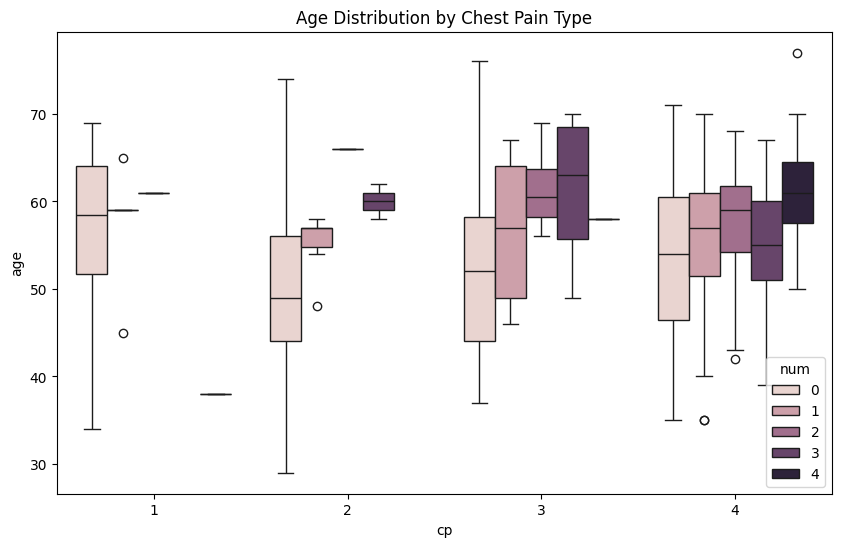

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="cp",y="age",hue="num",data=df)

plt.title('Age Distribution by Chest Pain Type')
plt.xlabel('Chest Pain Type (cp)')
plt.ylabel('Age')
plt.show()

## Exercise 3: Dummy Coding

Perform categorical regression with `cp` as the outcome variable and `age` as the predictors. For this:

1. In the documentation, inspect the "Additional Variable Information" to find out about the different levels of chest pain
2. Convert chest pain into a categorical variable
3. Apply a dummy coding scheme with typical angina as the reference category
4. Discuss the following points:
    - What do the coefficients tell you about the relationship between age and different types of chest pain?
    - Considering the explained variance and significance. Do the results suggest a relationship between chest pain type and age? Why or why not?

In [4]:
# Convert 'cp' to categorical variables
df['cp'] = df['cp'].astype('category')

# Run the model
model = smf.ols('age ~ C(cp, Treatment(reference=1))', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.364
Date:                Wed, 11 Dec 2024   Prob (F-statistic):             0.0191
Time:                        11:24:18   Log-Likelihood:                -1091.5
No. Observations:                 303   AIC:                             2191.
Df Residuals:                     299   BIC:                             2206.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

### Solution

The only significant difference observed is between typical and atypical angina, with patients displaying significantly younger ages and a higher prevalence of atypical angina. No other categories show significance. However, the model explains only 3.3% of the variance in age. While the significance is low in terms of explanatory power, it is important to note that in clinical contexts, the explained variance is often lower due to the complex mechanisms underlying health issues, which cannot be fully captured by such simple models.

## Exercise 4: Weighted Effects Coding

1. Create a weighted effects coding contrast matrix with `age` as the outcome variable and `cp` as the predictors. Use 1 (typical angina) as the reference category, as in the previous steps.
2. Perform linear regression using `ols()` from `Statsmodels` with the weighted effects coding matrix.
3. Compare and interpret the results against the previous dummy coding approach, specifically focusing on the impact of using a weighted reference category versus an unweighted reference. How does the weighting affect the interpretation of the relationship between cp and age?

In [5]:
# Calculate sample sizes for each chest pain type
levels = df['cp'].cat.categories.tolist()
cp_counts = df['cp'].value_counts(sort=False)
counts = cp_counts.values

print("Levels:", levels)
print("Counts:", counts)


contrast_matrix = {
    1: -counts[:-1] / counts[-1], # typical angina
    2: np.array([1, 0, 0]),       # atypical angina
    3: np.array([0, 1, 0]),       # non-anginal pain
    4: np.array([0, 0, 1]),       # asymptomatic
}

# Print each genotype's corresponding contrast vector
print("\nContrasts:")
for key, value in contrast_matrix.items():
    print(f"{key}: {value}")

# Create the design matrix and outcome vector
X = np.array([contrast_matrix[cp] for cp in df['cp']])
X = sm.add_constant(X)
y = df['age']

# Fit the model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


Levels: [1, 2, 3, 4]
Counts: [ 23  50  86 144]

Contrasts:
1: [-0.15972222 -0.34722222 -0.59722222]
2: [1 0 0]
3: [0 1 0]
4: [0 0 1]
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.364
Date:                Wed, 11 Dec 2024   Prob (F-statistic):             0.0191
Time:                        11:24:18   Log-Likelihood:                -1091.5
No. Observations:                 303   AIC:                             2191.
Df Residuals:                     299   BIC:                             2206.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

### Solution

- Dummy Coding provides simple, clear comparisons against a single fixed group (like Asymptomatic), but the interpretation can be sensitive to imbalances in the reference group.
- Weighted Effect Coding offers a more balanced comparison, as it adjusts the reference category to account for differences in group sizes. This results in coefficients that are more representative of the overall structure of the data.
- Atypical Angina and Asymptomatic have clearer interpretations in the weighted model.
- The weighted model also gives a more accurate sense of how each group relates to the other chest pain categories, as it doesn’t rely on any one group being a fixed reference.

## Voluntary exercise 1

With the model as previously designed in Exercise 2:

1. Manually create the contrast matrix and print it
2. Create and print the design matrix

*Hint: You can create the design matrix from the contrast matrix, but you need to map each level in `cp` to the corresponding contrast row: `cp_mapping = {level: idx for idx, level in enumerate(levels)}`.*



In [6]:
# Get the levels of 'cp'
levels = df['cp'].cat.categories.tolist()
print("Levels:", levels)

#  Create a Treatment contrast object
contrast = Treatment(reference=1)  # Set the reference level to atypical angina

# Contrast matrix
contrast_matrix = contrast.code_without_intercept(levels)
print("\nContrast matrix:\n", contrast_matrix.matrix)

# Map each value in 'cp' to its corresponding contrast row
cp_mapping = {level: idx for idx, level in enumerate(levels)}
print("Mapping:", cp_mapping)

# Create the design matrix
X = np.array([contrast_matrix.matrix[cp_mapping[cp]] for cp in df['cp']])
X = sm.add_constant(X)  # Add intercept

print("\nDesign matrix:\n", X)

Levels: [1, 2, 3, 4]

Contrast matrix:
 [[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Mapping: {1: 0, 2: 1, 3: 2, 4: 3}

Design matrix:
 [[1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 ...
 [1. 0. 0. 1.]
 [1. 1. 0. 0.]
 [1. 0. 1. 0.]]


## Voluntary exercise 2

Implement contrast coding on the heart disease data set. There are no constraints, feel free to explore any contrasts.

In [7]:
# Voluntary exercise 2